# 1. Set up and load the data

In [1]:
# Set up the required imports.

import time
from functools import partial
from multiprocessing import Pool, cpu_count

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats

from typing import Dict, Tuple, Optional

In [2]:
# Define dataset name.

# DATASET = 'adamson_2016_pilot_curated'
DATASET = 'adamson_2016_upr_epistasis_curated'
# DATASET = 'adamson_2016_upr_perturb_seq_curated'
# DATASET = 'datlinger_2017_curated'
# DATASET = 'orion_2025_hct116_curated'
# DATASET = 'orion_2025_hek293t_curated'

In [3]:
# Copy dataset from storage.

! gsutil cp gs://perturbation-catalogue-lake/perturbseq/curated/{DATASET}.h5ad /tmp/{DATASET}.h5ad

Copying gs://perturbation-catalogue-lake/perturbseq/curated/adamson_2016_upr_epistasis_curated.h5ad...
| [1 files][480.5 MiB/480.5 MiB]   25.9 MiB/s                                   
Operation completed over 1 objects/480.5 MiB.                                    


In [4]:
# Load the h5ad file.

adata = sc.read_h5ad(f'/tmp/{DATASET}.h5ad')

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# FIX: adata.var index structure.

adata.var.drop(columns=['gene_symbol'], inplace=True)
adata.var.index.name = 'gene_symbol'
adata.var.reset_index(inplace=True)
adata.var.set_index('gene_symbol', inplace=True)
adata.var['gene_symbol'] = adata.var.index

In [6]:
# FIX: downsample controls.

adata.obs['perturbed_target_symbol'] = adata.obs['perturbed_target_symbol'].str.replace(r'^control.*', 'control', regex=True).astype("category")

In [7]:
# FIX: filter out `nan` perturbations

adata = adata[adata.obs['perturbed_target_symbol'].notna(), :].copy()

In [8]:
# Overview of the file.

adata

AnnData object with n_obs × n_vars = 14695 × 32738
    obs: 'perturbation_name', 'perturbed_target_coord', 'perturbed_target_number', 'perturbed_target_ensg', 'perturbed_target_symbol', 'perturbed_target_biotype', 'guide_sequence', 'perturbation_type_label', 'perturbation_type_id', 'timepoint', 'treatment_label', 'treatment_id', 'model_system_label', 'model_system_id', 'species', 'tissue_label', 'tissue_id', 'cell_type_label', 'cell_type_id', 'cell_line_label', 'cell_line_id', 'sex_label', 'sex_id', 'developmental_stage_label', 'developmental_stage_id', 'disease_label', 'disease_id'
    var: 'ensembl_gene_id', 'gene_symbol'

In [9]:
# High level look at the observations.

adata.obs

,perturbation_name,perturbed_target_coord,perturbed_target_number,perturbed_target_ensg,perturbed_target_symbol,perturbed_target_biotype,guide_sequence,perturbation_type_label,perturbation_type_id,timepoint,...,cell_type_label,cell_type_id,cell_line_label,cell_line_id,sex_label,sex_id,developmental_stage_label,developmental_stage_id,disease_label,disease_id
0,3x_neg_ctrl_pMJ144-1,NaN,2,control|None,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
1,3x_neg_ctrl_pMJ144-2,NaN,2,control|None,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
2,3x_neg_ctrl_pMJ144-2,NaN,2,control|None,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
3,ATF6_PERK_IRE1_pMJ158,chr1:161766298-161977574;1|chr2:88556741-88691...,3,ENSG00000118217|ENSG00000172071|ENSG00000178607,ATF6|EIF2AK3|ERN1,protein_coding|protein_coding|protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
4,ATF6_PERK_pMJ150,chr1:161766298-161977574;1|chr2:88556741-88691...,2,ENSG00000118217|ENSG00000172071,ATF6|EIF2AK3,protein_coding|protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14692,PERK_only_pMJ146,chr2:88556741-88691518;-1,1,ENSG00000172071,EIF2AK3,protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
14693,PERK_IRE1_pMJ154,chr2:88556741-88691518;-1|chr17:64039080-64130...,2,ENSG00000172071|ENSG00000178607,EIF2AK3|ERN1,protein_coding|protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
14694,3x_neg_ctrl_pMJ144-1,NaN,2,control|None,control,NaN,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
14695,PERK_IRE1_pMJ154,chr2:88556741-88691518;-1|chr17:64039080-64130...,2,ENSG00000172071|ENSG00000178607,EIF2AK3|ERN1,protein_coding|protein_coding,NaN,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996


In [10]:
# High level look at the genes.

adata.var

,ensembl_gene_id,gene_symbol
gene_symbol,,
MIR1302-10,ENSG00000243485,MIR1302-10
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
RP11-34P13.7,ENSG00000238009,RP11-34P13.7
RP11-34P13.8,ENSG00000239945,RP11-34P13.8
...,...,...
AC145205.1,ENSG00000215635,AC145205.1
BAGE5,ENSG00000268590,BAGE5
CU459201.1,ENSG00000251180,CU459201.1


# 2. Perturbed genes statistics

Total number of distinct perturbed genes: 14
First 10 perturbed genes: ['ATF6|EIF2AK3|ERN1', 'ATF6|EIF2AK3', 'ATF6', 'EIF2AK3|ERN1', 'ATF6|ERN1', 'ERN1', 'EIF2AK3', 'XBP1P1', 'IER3IP1', 'PSMA1']


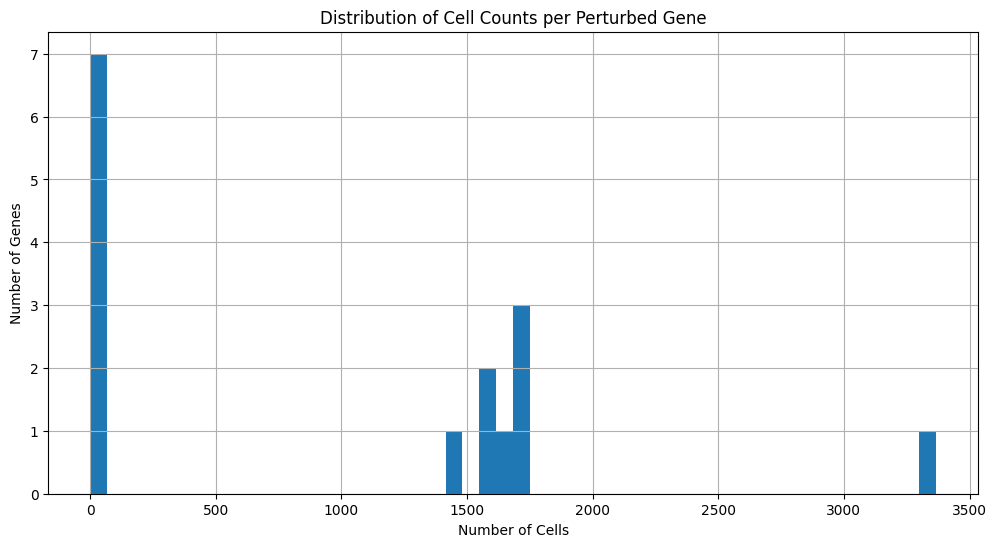


Statistics of cells per perturbed gene:
count      15.000000
mean      979.666667
std      1043.867580
min         1.000000
25%         3.000000
50%      1449.000000
75%      1657.000000
max      3366.000000
Name: count, dtype: float64


In [11]:
# Get all unique perturbation targets (including 'control')
all_targets = adata.obs['perturbed_target_symbol'].unique()

# Filter out 'control' to get only perturbed genes
perturbed_targets = [t for t in all_targets if t != 'control']
num_perturbed_genes = len(perturbed_targets)

print(f"Total number of distinct perturbed genes: {num_perturbed_genes}")
print("First 10 perturbed genes:", perturbed_targets[:10])

# Count number of cells per perturbed gene
target_counts = adata.obs['perturbed_target_ensg'].value_counts()

# Remove 'control' from the counts for plotting
perturbation_counts = target_counts[target_counts.index != 'control']

# Plot histogram
plt.figure(figsize=(12, 6))
perturbation_counts.hist(bins=50)
plt.title('Distribution of Cell Counts per Perturbed Gene')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.grid(True)
plt.show()

# Show some statistics
print("\nStatistics of cells per perturbed gene:")
print(perturbation_counts.describe())

# 3. Cell type statistics

Total number of distinct cell types: 1
All cell types: ['lymphoblast']
Categories (1, object): ['lymphoblast']


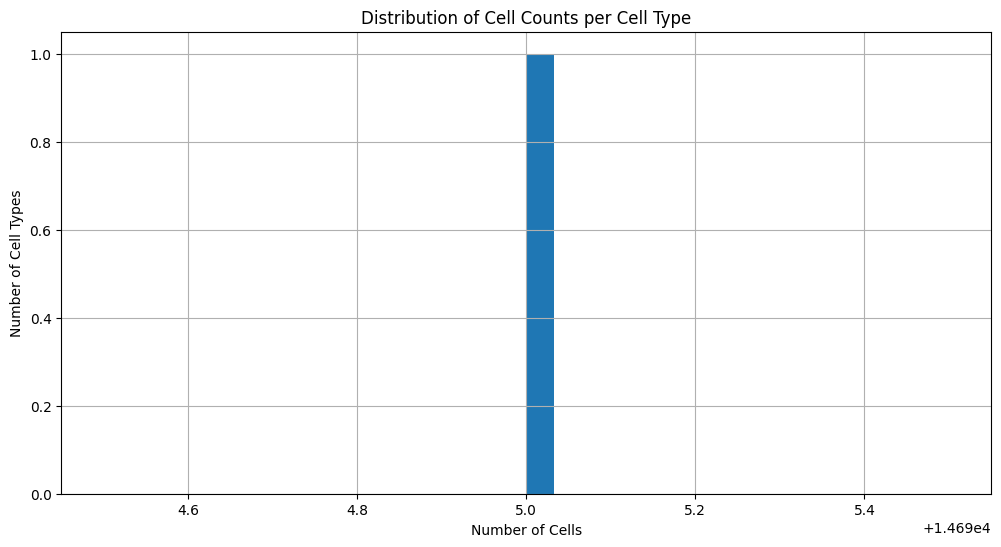

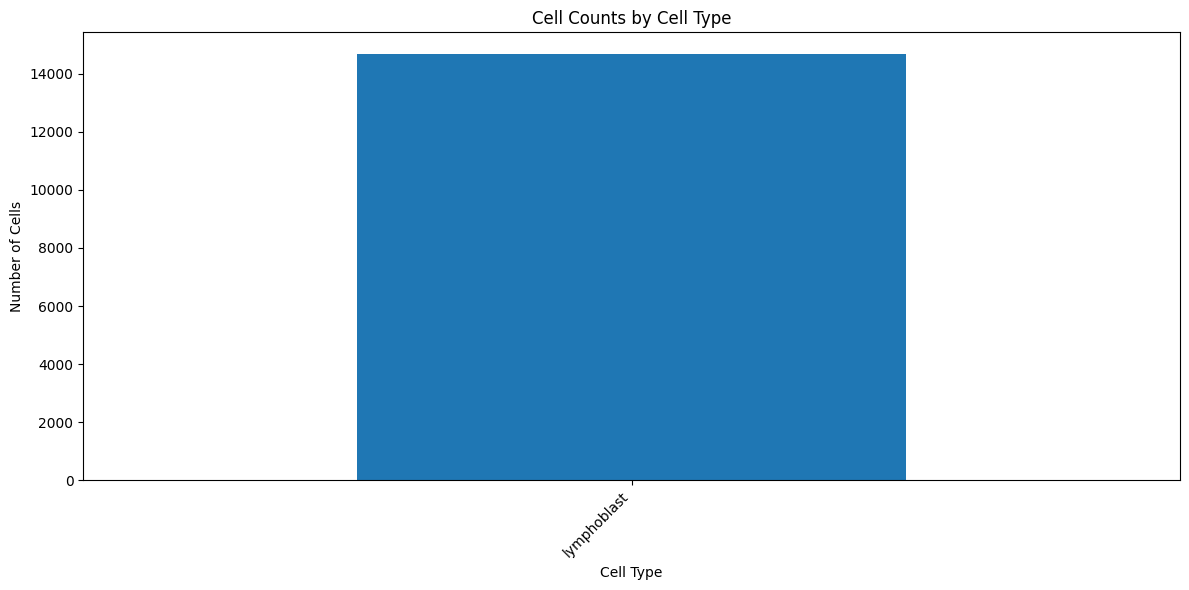


Statistics of cells per cell type:
count        1.0
mean     14695.0
std          NaN
min      14695.0
25%      14695.0
50%      14695.0
75%      14695.0
max      14695.0
Name: count, dtype: float64

Complete cell type distribution:
cell_type_label
lymphoblast    14695
Name: count, dtype: int64


In [12]:
# Get all unique cell types
cell_types = adata.obs['cell_type_label'].unique()
num_cell_types = len(cell_types)

print(f"Total number of distinct cell types: {num_cell_types}")
print("All cell types:", cell_types)

# Count number of cells per cell type
cell_type_counts = adata.obs['cell_type_label'].value_counts()

# Plot histogram
plt.figure(figsize=(12, 6))
cell_type_counts.hist(bins=30)
plt.title('Distribution of Cell Counts per Cell Type')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Cell Types')
plt.grid(True)
plt.show()

# Plot as bar chart for better readability
plt.figure(figsize=(12, 6))
cell_type_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Cell Counts by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show some statistics
print("\nStatistics of cells per cell type:")
print(cell_type_counts.describe())

# Show the complete distribution
print("\nComplete cell type distribution:")
print(cell_type_counts)

# 4. Levels of expression of control genes

Original data shape: (14695, 32738)
Control data shape: (3366, 32738)
Number of genes: 32738
Mean expression range: 0.0000 to 436.2606


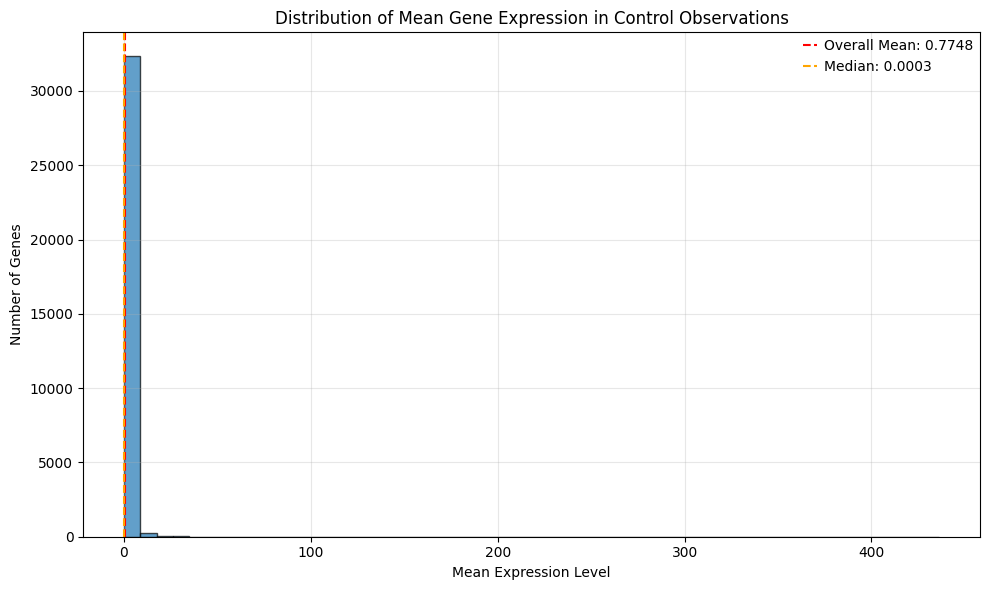


Summary statistics for mean gene expression:
Mean: 0.7748
Median: 0.0003
Standard deviation: 7.4334
25th percentile: 0.0000
75th percentile: 0.1236

Available housekeeping genes and their mean expression:
  RPL13A: 227.4076
  RPLP0: 127.3143
  GAPDH: 85.2888
  ACTB: 46.8096
  B2M: 23.9088
  TUBB: 19.2243
  LDHA: 16.3907
  PPIA: 14.1521
  PGK1: 7.8336
  TFRC: 2.6477
  YWHAZ: 1.9138
  HPRT1: 1.1557
  GUSB: 0.9902
  TBP: 0.3375

Selected highly expressed housekeeping gene: RPL13A (mean: 227.4076)


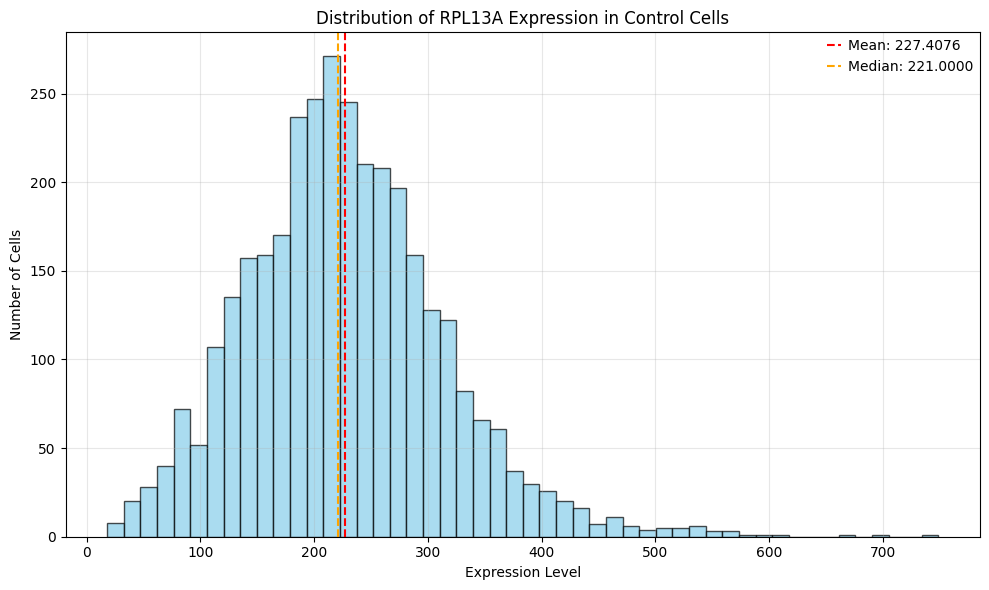


Summary statistics for RPL13A expression:
Mean: 227.4076
Median: 221.0000
Standard deviation: 87.2499
Min: 18.0000
Max: 749.0000
Number of cells: 3366


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Filter adata to keep only control observations
control_mask = adata.obs['perturbed_target_symbol'] == 'control'
adata_control = adata[control_mask, :].copy()

print(f"Original data shape: {adata.shape}")
print(f"Control data shape: {adata_control.shape}")

# Calculate mean expression per gene across control observations
mean_expression = np.array(adata_control.X.mean(axis=0)).flatten()

print(f"Number of genes: {len(mean_expression)}")
print(f"Mean expression range: {mean_expression.min():.4f} to {mean_expression.max():.4f}")

# Create histogram of mean gene expression values
plt.figure(figsize=(10, 6))
plt.hist(mean_expression, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Mean Expression Level')
plt.ylabel('Number of Genes')
plt.title('Distribution of Mean Gene Expression in Control Observations')
plt.grid(True, alpha=0.3)

# Add some summary statistics to the plot
plt.axvline(np.mean(mean_expression), color='red', linestyle='--', 
           label=f'Overall Mean: {np.mean(mean_expression):.4f}')
plt.axvline(np.median(mean_expression), color='orange', linestyle='--', 
           label=f'Median: {np.median(mean_expression):.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Print some summary statistics
print(f"\nSummary statistics for mean gene expression:")
print(f"Mean: {np.mean(mean_expression):.4f}")
print(f"Median: {np.median(mean_expression):.4f}")
print(f"Standard deviation: {np.std(mean_expression):.4f}")
print(f"25th percentile: {np.percentile(mean_expression, 25):.4f}")
print(f"75th percentile: {np.percentile(mean_expression, 75):.4f}")

# Find a highly expressed housekeeping gene
housekeeping_genes = ['ACTB', 'GAPDH', 'B2M', 'HPRT1', 'TBP', 'RPLP0', 'RPL13A', 
                      'PPIA', 'YWHAZ', 'GUSB', 'TFRC', 'PGK1', 'LDHA', '18S', 'TUBB']

# Check which housekeeping genes are present in the data
available_hk_genes = []
for gene in housekeeping_genes:
    if gene in adata_control.var.gene_symbol:
        gene_idx = adata_control.var.index.get_loc(gene)
        mean_expr = mean_expression[gene_idx]
        available_hk_genes.append((gene, mean_expr))

if available_hk_genes:
    # Sort by mean expression and pick the highest one
    available_hk_genes.sort(key=lambda x: x[1], reverse=True)
    selected_gene, selected_mean = available_hk_genes[0]
    
    print(f"\nAvailable housekeeping genes and their mean expression:")
    for gene, expr in available_hk_genes:
        print(f"  {gene}: {expr:.4f}")
    
    print(f"\nSelected highly expressed housekeeping gene: {selected_gene} (mean: {selected_mean:.4f})")
    
    # Get expression values for the selected gene across all control cells
    gene_idx = adata_control.var.index.get_loc(selected_gene)
    # Handle both sparse and dense matrices
    if hasattr(adata_control.X, 'toarray'):
        # Sparse matrix
        gene_expression = adata_control.X[:, gene_idx].toarray().flatten()
    else:
        # Dense matrix
        gene_expression = np.array(adata_control.X[:, gene_idx]).flatten()
    
    # Plot distribution of the selected housekeeping gene
    plt.figure(figsize=(10, 6))
    plt.hist(gene_expression, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.xlabel('Expression Level')
    plt.ylabel('Number of Cells')
    plt.title(f'Distribution of {selected_gene} Expression in Control Cells')
    plt.grid(True, alpha=0.3)
    
    # Add summary statistics to the plot
    plt.axvline(np.mean(gene_expression), color='red', linestyle='--', 
               label=f'Mean: {np.mean(gene_expression):.4f}')
    plt.axvline(np.median(gene_expression), color='orange', linestyle='--', 
               label=f'Median: {np.median(gene_expression):.4f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for the selected gene
    print(f"\nSummary statistics for {selected_gene} expression:")
    print(f"Mean: {np.mean(gene_expression):.4f}")
    print(f"Median: {np.median(gene_expression):.4f}")
    print(f"Standard deviation: {np.std(gene_expression):.4f}")
    print(f"Min: {np.min(gene_expression):.4f}")
    print(f"Max: {np.max(gene_expression):.4f}")
    print(f"Number of cells: {len(gene_expression)}")
    
else:
    print(f"\nNo common housekeeping genes found in the dataset.")
    print("Available gene names (first 20):", list(adata_control.var.gene_symbol[:20]))
    print("You may need to check the gene naming convention (e.g., ENSEMBL IDs vs gene symbols)")

# 5. Pseudobulk differential expression

In [14]:
def _compute_ttest_chunk(args):
    """Helper function for parallel t-test computation"""
    X_control, X_perturbed, gene_indices = args
    pvalues = []
    
    for gene_idx in gene_indices:
        control_vals = X_control[:, gene_idx]
        perturbed_vals = X_perturbed[:, gene_idx]
                
        try:
            _, pval = stats.ttest_ind(perturbed_vals, control_vals)
            pvalues.append(pval)
        except:
            pvalues.append(1.0)
    
    return pvalues

In [15]:
def compute_pseudobulk_perturbation_analysis(
    adata, 
    perturbation_col: str = "perturbed_target_symbol",
    control_label: str = "control",  # or "non-targeting", adjust as needed
    min_cells_per_group: int = 10,
    log_transform: bool = True,
    n_jobs: int = -1,
    chunk_size: int = 500,
    min_expression_threshold: float = 10.0
) -> pd.DataFrame:
    """
    Compute pseudobulk analysis for perturbation data with parallel processing.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object with perturbation expression results
    perturbation_col : str
        Column name in adata.obs containing perturbation target symbols
    control_label : str
        Label used for control/non-targeting samples
    min_cells_per_group : int
        Minimum number of cells required per perturbation group
    log_transform : bool
        Whether to log-transform the data before analysis
    n_jobs : int
        Number of parallel jobs (-1 for all cores)
    chunk_size : int
        Number of genes to process per chunk in parallel
    min_expression_threshold : float
        Minimum pseudobulk control expression to include gene in analysis
        
    Returns:
    --------
    pd.DataFrame
        Results with columns: perturbation, gene, log2fc, pvalue, padj, mean_control, mean_perturbed
    """
    
    start_time = time.time()
    print(f"Starting pseudobulk analysis...")
    print(f"Dataset shape: {adata.shape}")
    
    # Check if perturbation column exists
    if perturbation_col not in adata.obs.columns:
        raise ValueError(f"Column '{perturbation_col}' not found in adata.obs")
    
    print(f"✓ Found perturbation column: {perturbation_col}")
    
    # Get expression data
    print("📊 Loading expression data...")
    if hasattr(adata.X, 'toarray'):
        X = adata.X.toarray()  # Convert sparse to dense if needed
        print("  Converted sparse matrix to dense")
    else:
        X = adata.X
    
    # Log transform if requested and data doesn't appear to be log-transformed
    if log_transform and np.max(X) > 20:  # Simple check for non-log data
        print("🔄 Applying log1p transformation...")
        X = np.log1p(X)
        print("  ✓ Log transformation complete")
    else:
        print("  Data appears already log-transformed or log_transform=False")
    
    # Get perturbation labels
    print("🏷️  Processing perturbation labels...")
    perturbations = adata.obs[perturbation_col].values
    
    www = set(perturbations)
    print(www)
    print([type(_) for _ in www])
    
    unique_perturbations = np.unique(perturbations)
    print(f"  Found {len(unique_perturbations)} unique perturbations")
    
    # Filter out perturbations with too few cells
    print(f"🔍 Filtering perturbations (min {min_cells_per_group} cells)...")
    valid_perturbations = []
    for pert in unique_perturbations:
        cell_count = np.sum(perturbations == pert)
        if cell_count >= min_cells_per_group:
            valid_perturbations.append(pert)
            print(f"  ✓ {pert}: {cell_count} cells")
        else:
            print(f"  ✗ Skipping {pert}: only {cell_count} cells")
    
    if control_label not in valid_perturbations:
        raise ValueError(f"Control label '{control_label}' not found or has too few cells")
    
    print(f"✓ Will analyze {len(valid_perturbations)} perturbations")
    
    # Compute pseudobulk (mean expression per perturbation)
    print("🧮 Computing pseudobulk (mean expression per perturbation)...")
    pseudobulk_data = {}
    for i, pert in enumerate(valid_perturbations):
        print(f"  Processing {i+1}/{len(valid_perturbations)}: {pert}")
        mask = perturbations == pert
        pseudobulk_data[pert] = np.mean(X[mask, :], axis=0)
    
    # Convert to DataFrame for easier handling
    pseudobulk_df = pd.DataFrame(pseudobulk_data, index=adata.var.gene_symbol)
    print(f"✓ Pseudobulk computed. Shape: {pseudobulk_df.shape}")
    
    # Set up parallel processing
    if n_jobs == -1:
        n_jobs = cpu_count()
    print(f"⚡ Setting up parallel processing with {n_jobs} cores")
    
    # Compute statistics for each perturbation vs control
    print("📈 Computing differential expression statistics...")
    results = []
    control_expression = pseudobulk_df[control_label].values
    num_of_controls = len(control_expression)
    control_mask = perturbations == control_label
    X_control = X[control_mask, :]
    
    # Filter genes by expression threshold
    print(f"🔍 Filtering genes with control expression > {min_expression_threshold}")
    
    # Apply log1p to threshold if data was log-transformed
    if log_transform and np.max(X) <= 20:  # Data was log-transformed
        threshold_to_use = np.log1p(min_expression_threshold)
        print(f"  Using log1p-adjusted threshold: {threshold_to_use:.3f} (original: {min_expression_threshold})")
    else:
        threshold_to_use = min_expression_threshold
        print(f"  Using original threshold: {threshold_to_use}")
    
    expressed_genes_mask = control_expression * num_of_controls > threshold_to_use
    n_expressed = np.sum(expressed_genes_mask)
    print(f"  ✓ {n_expressed}/{len(control_expression)} genes pass expression threshold")
    
    if n_expressed == 0:
        raise ValueError(f"No genes pass expression threshold {min_expression_threshold}")
    
    for pert_idx, pert in enumerate(valid_perturbations):
        if pert == control_label:
            continue
            
        print(f"  Processing perturbation {pert_idx+1}/{len(valid_perturbations)}: {pert}")
        
        perturbed_expression = pseudobulk_df[pert].values
        perturbed_mask = perturbations == pert
        X_perturbed = X[perturbed_mask, :]
        
        # Filter for expressed genes only
        control_expr_filtered = control_expression[expressed_genes_mask]
        perturbed_expr_filtered = perturbed_expression[expressed_genes_mask]
        X_control_filtered = X_control[:, expressed_genes_mask]
        X_perturbed_filtered = X_perturbed[:, expressed_genes_mask]
        expressed_gene_names = adata.var.gene_symbol[expressed_genes_mask].tolist()  # Convert to list to preserve strings
        
        # Compute log2 fold change (vectorized)
        print("    Computing fold changes...")
        pseudocount = 1e-8
        log2fc = np.log2((perturbed_expr_filtered + pseudocount) / (control_expr_filtered + pseudocount))
        
        # Parallel t-test computation
        print(f"    Computing p-values using {n_jobs} cores...")
        n_genes_filtered = X_control_filtered.shape[1]
        
        # Create chunks for parallel processing
        gene_chunks = [list(range(i, min(i + chunk_size, n_genes_filtered))) 
                      for i in range(0, n_genes_filtered, chunk_size)]
        
        print(f"    Split {n_genes_filtered} expressed genes into {len(gene_chunks)} chunks")
        
        # Prepare arguments for parallel processing
        args_list = [(X_control_filtered, X_perturbed_filtered, chunk) for chunk in gene_chunks]
        
        # Run parallel t-tests
        with Pool(n_jobs) as pool:
            chunk_results = pool.map(_compute_ttest_chunk, args_list)
        
        # Flatten results
        pvalues = []
        for chunk_pvals in chunk_results:
            pvalues.extend(chunk_pvals)
        
        pvalues = np.array(pvalues)
        print(f"    ✓ Computed {len(pvalues)} p-values")
        
        # Multiple testing correction (Benjamini-Hochberg)
        print("    Applying multiple testing correction...")
        from statsmodels.stats.multitest import multipletests
        
        # Handle NaN p-values before correction
        valid_pvals = ~np.isnan(pvalues)
        if np.sum(valid_pvals) == 0:
            print("    ⚠️  All p-values are NaN, skipping correction")
            padj = np.full_like(pvalues, np.nan)
        else:
            # Initialize padj array
            padj = np.full_like(pvalues, np.nan)
            # Only correct valid p-values
            _, padj_valid, _, _ = multipletests(pvalues[valid_pvals], method='fdr_bh')
            padj[valid_pvals] = padj_valid
        
        # Create results for this perturbation (only for expressed genes)
        print("    Compiling results...")
        for gene_idx, gene_name in enumerate(expressed_gene_names):
            # Ensure gene_name is a string
            gene_name_str = str(gene_name)
            results.append({
                'perturbation': pert,
                'gene': gene_name_str,
                'log2fc': log2fc[gene_idx],
                'pvalue': pvalues[gene_idx],
                'padj': padj[gene_idx],
                'mean_control': control_expr_filtered[gene_idx],
                'mean_perturbed': perturbed_expr_filtered[gene_idx]
            })
        
        print(f"    ✓ {pert} complete")
    
    print("📋 Finalizing results...")
    results_df = pd.DataFrame(results)
    
    # Sort by perturbation and p-value
    results_df = results_df.sort_values(['perturbation', 'pvalue'])
    
    total_time = time.time() - start_time
    print(f"🎉 Analysis complete! Total time: {total_time:.2f} seconds")
    print(f"   Analyzed {results_df['perturbation'].nunique()} perturbations")
    print(f"   Total comparisons: {len(results_df):,}")
    
    return results_df

In [16]:
def plot_volcano_plot(results_df, perturbation_name, 
                     pval_threshold=0.05, fc_threshold=1.0, 
                     top_n_genes=10):
    """
    Create a volcano plot for a specific perturbation.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from compute_pseudobulk_perturbation_analysis
    perturbation_name : str
        Name of the perturbation to plot
    pval_threshold : float
        P-value threshold for significance
    fc_threshold : float
        Fold change threshold (absolute log2 fold change)
    top_n_genes : int
        Number of top genes to label
    """
    import matplotlib.pyplot as plt
    
    # Filter for specific perturbation
    pert_data = results_df[results_df['perturbation'] == perturbation_name].copy()
    
    if len(pert_data) == 0:
        print(f"No data found for perturbation: {perturbation_name}")
        print(f"Available perturbations: {results_df['perturbation'].unique()}")
        return
    
    # Remove rows with NaN values for plotting
    pert_data = pert_data.dropna(subset=['padj', 'log2fc'])
    
    if len(pert_data) == 0:
        print(f"No valid data points for perturbation: {perturbation_name} after removing NaN values")
        return
    
    print(f"Plotting {len(pert_data)} genes for {perturbation_name}")
    
    # Create significance categories
    pert_data['significant'] = (pert_data['padj'] < pval_threshold) & (np.abs(pert_data['log2fc']) > fc_threshold)
    
    print(f"Found {np.sum(pert_data['significant'])} significant genes")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot non-significant points
    non_sig = pert_data[~pert_data['significant']]
    if len(non_sig) > 0:
        ax.scatter(non_sig['log2fc'], -np.log10(non_sig['padj']), 
                  alpha=0.5, color='gray', s=20, label=f'Non-significant ({len(non_sig)})')
    
    # Plot significant points
    sig = pert_data[pert_data['significant']]
    if len(sig) > 0:
        ax.scatter(sig['log2fc'], -np.log10(sig['padj']), 
                  alpha=0.7, color='red', s=30, label=f'Significant ({len(sig)})')
    
    # Add threshold lines
    ax.axhline(-np.log10(pval_threshold), color='blue', linestyle='--', alpha=0.5, 
               label=f'padj = {pval_threshold}')
    ax.axvline(fc_threshold, color='blue', linestyle='--', alpha=0.5)
    ax.axvline(-fc_threshold, color='blue', linestyle='--', alpha=0.5)
    
    # Label top genes (by most significant padj)
    top_genes = pert_data.nsmallest(top_n_genes, 'padj')
    for _, gene in top_genes.iterrows():
        if not np.isnan(gene['padj']) and gene['padj'] > 0:  # Only label if valid padj
            ax.annotate(gene['gene'], 
                       (gene['log2fc'], -np.log10(gene['padj'])),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)
    
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(f'Volcano Plot: {perturbation_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add some statistics to the plot
    stats_text = f"Total genes: {len(pert_data)}\n"
    stats_text += f"Significant: {np.sum(pert_data['significant'])}\n"
    stats_text += f"FC threshold: ±{fc_threshold}\n"
    stats_text += f"padj threshold: {pval_threshold}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\nSummary for {perturbation_name}:")
    print(f"  Total genes plotted: {len(pert_data)}")
    print(f"  Significant genes: {np.sum(pert_data['significant'])}")
    print(f"  Mean |log2FC|: {np.mean(np.abs(pert_data['log2fc'])):.3f}")
    print(f"  Min padj: {np.min(pert_data['padj']):.2e}")
    if len(sig) > 0:
        print(f"  Top significant gene: {sig.loc[sig['padj'].idxmin(), 'gene']} (padj={sig['padj'].min():.2e})")

In [17]:
# Run the analysis

results = compute_pseudobulk_perturbation_analysis(
    adata, 
    perturbation_col="perturbed_target_symbol",
    control_label="control",
    min_cells_per_group=10,
    n_jobs=-1,  # Use all available cores
    chunk_size=500,  # Process 500 genes per chunk
    min_expression_threshold=10.0  # Only analyze genes with control expression > 10
)

Starting pseudobulk analysis...
Dataset shape: (14695, 32738)
✓ Found perturbation column: perturbed_target_symbol
📊 Loading expression data...
  Converted sparse matrix to dense
🔄 Applying log1p transformation...
  ✓ Log transformation complete
🏷️  Processing perturbation labels...
{'PSMD12', 'EIF2AK3|ERN1', 'SNAI1', 'PSMA1', 'ATF4', 'control', 'ATF6|EIF2AK3', 'ATF6|EIF2AK3|ERN1', 'ATF6', 'ERN1', 'IER3IP1', 'ATF6|ERN1', 'YIPF5', 'EIF2AK3', 'XBP1P1'}
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]
  Found 15 unique perturbations
🔍 Filtering perturbations (min 10 cells)...
  ✗ Skipping ATF4: only 1 cells
  ✓ ATF6: 1691 cells
  ✓ ATF6|EIF2AK3: 1603 cells
  ✓ ATF6|EIF2AK3|ERN1: 1693 cells
  ✓ ATF6|ERN1: 1449 cells
  ✓ EIF2AK3: 1560 cells
  ✓ EIF2AK3|ERN1: 1629 cells
  ✓ ERN1: 1685 cells
  ✗ Skipping IER3IP1: only 

In [18]:
results

,perturbation,gene,log2fc,pvalue,padj,mean_control,mean_perturbed
1354,ATF6,ATF6,-2.735865,8.938098e-191,1.585619e-186,0.448546,0.067333
11371,ATF6,HSP90B1,-0.384050,7.817525e-175,6.934145e-171,2.639173,2.022355
8863,ATF6,HSPA5,-0.516776,2.765665e-142,1.635430e-138,2.727172,1.906108
17153,ATF6,SDF2L1,-0.262394,4.984424e-138,2.210592e-134,4.720498,3.935495
3947,ATF6,DNAJB11,-0.434880,6.053620e-96,2.147824e-92,1.770011,1.309375
...,...,...,...,...,...,...,...
122441,ERN1,HNRNPM,-0.000008,9.998344e-01,9.999620e-01,1.743358,1.743348
117656,ERN1,CTDSP2,0.000014,9.998804e-01,9.999620e-01,0.446814,0.446819
108372,ERN1,GEN1,0.000017,9.998905e-01,9.999620e-01,0.087496,0.087497
118167,ERN1,AKAP11,0.000002,9.999169e-01,9.999620e-01,0.176919,0.176919


In [19]:
# Display summary

print(f"Analyzed {results['perturbation'].nunique()} perturbations")
print(f"Total comparisons: {len(results)}")

Analyzed 7 perturbations
Total comparisons: 124180


In [20]:
# Check for NaN padj values

nan_padj = results['padj'].isna().sum()
if nan_padj > 0:
    print(f"Warning: {nan_padj} entries have NaN adjusted p-values")

In [21]:
# Show top results for each perturbation

for pert in results['perturbation'].unique():
    print(f"\nTop 10 most significant genes for {pert}:")
    pert_results = results[results['perturbation'] == pert]
    # Filter out NaN padj for display
    pert_results_clean = pert_results.dropna(subset=['padj'])
    if len(pert_results_clean) > 0:
        top5 = pert_results_clean.nsmallest(10, 'padj')[['gene', 'log2fc', 'pvalue', 'padj']]
        print(top5.to_string(index=False))
    else:
        print("  No valid results (all padj are NaN)")


Top 10 most significant genes for ATF6:
   gene    log2fc        pvalue          padj
   ATF6 -2.735865 8.938098e-191 1.585619e-186
HSP90B1 -0.384050 7.817525e-175 6.934145e-171
  HSPA5 -0.516776 2.765665e-142 1.635430e-138
 SDF2L1 -0.262394 4.984424e-138 2.210592e-134
DNAJB11 -0.434880  6.053620e-96  2.147824e-92
  PDIA4 -0.505704  4.093411e-91  1.210285e-87
 CRELD2 -0.557252  1.062572e-90  2.692861e-87
   MANF -0.398068  1.482414e-89  3.287253e-86
  DERL3 -1.211092  2.956200e-79  5.826998e-76
TMEM50B -0.574777  2.851829e-67  5.059144e-64

Top 10 most significant genes for ATF6|EIF2AK3:
   gene    log2fc        pvalue          padj
  DDIT3 -1.397063  0.000000e+00  0.000000e+00
  HSPA5 -0.777771 4.533313e-259 4.021049e-255
HERPUD1 -1.167055 1.607319e-241 9.504612e-238
  HSPA8  0.618768 2.436791e-234 1.080717e-230
  TRIB3 -1.029156 1.996500e-223 7.083582e-220
 SDF2L1 -0.340695 2.920957e-208 8.636295e-205
HSP90B1 -0.429480 4.243029e-203 1.075305e-199
  DDIT4 -1.400449 1.447499e-201 3.20

Plotting 17740 genes for ATF6|EIF2AK3|ERN1
Found 264 significant genes


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


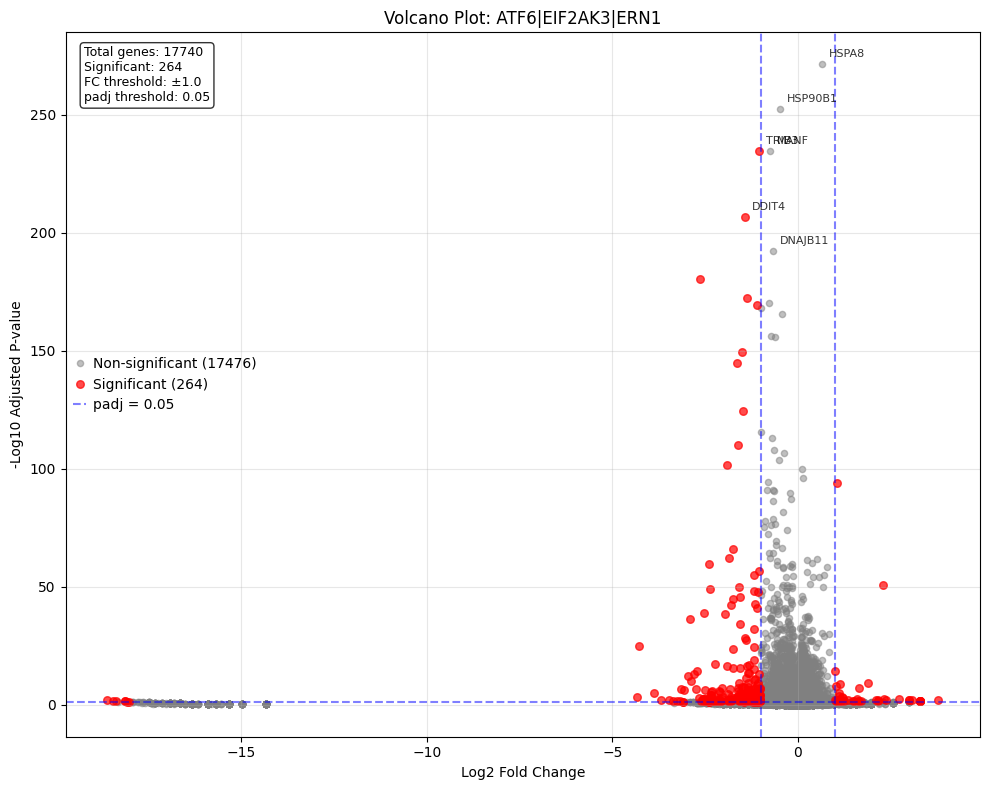


Summary for ATF6|EIF2AK3|ERN1:
  Total genes plotted: 17740
  Significant genes: 264
  Mean |log2FC|: 1.862
  Min padj: 0.00e+00
  Top significant gene: DDIT3 (padj=0.00e+00)


In [22]:
# Create volcano plot for a specific perturbation
plot_volcano_plot(results, perturbed_targets[0])

In [23]:
# Save results
results.to_csv(f"/tmp/{DATASET}.csv", index=False)

In [24]:
# Upload to Google Storage.
! gsutil cp /tmp/{DATASET}.csv gs://perturbation-catalogue-lake/perturbseq/differential_expression/{DATASET}.csv

Copying file:///tmp/adamson_2016_upr_epistasis_curated.csv [Content-Type=text/csv]...
/ [1 files][ 10.8 MiB/ 10.8 MiB]                                                
Operation completed over 1 objects/10.8 MiB.                                     
